In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the time series dataset
data = pd.read_csv('../datasets/complete_data/df.csv')

# Change column names to match naming convention
data = data.rename(columns={'start MTU (UTC)': 'ds', 'Day-ahead Price [EUR/MWh] BZN|NO1': 'y'})

# Convert the 'ds' column to datetime type
data['ds'] = pd.to_datetime(data['ds'])

In [3]:
# Extract the year, month, day and hour from the 'ds' column
data['month'] = data['ds'].dt.month
data['day'] = data['ds'].dt.day
data['hour'] = data['ds'].dt.hour

In [4]:
# Set the 'ds' column as the index of the dataframe
data.set_index('ds', inplace=True)
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [5]:
# Split the dataset into training, validation and testing sets
train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [6]:
# Lagged features
def create_lagged_dataset(df):
    # creating a copy of the dataframe
    lagged_df = df.copy()

    # Adding lagged features for target variable
    lagged_df['y'] = lagged_df['y'].shift(-1)

    # Dropping the last row containing NaN values
    lagged_df.dropna(inplace=True)

    # Creating a dataframe with lagged features with 24 steps for each of the original features
    lagged_df = pd.concat([lagged_df.shift(i) for i in range(24)], axis=1)

    # Removing the NaN rows that have been created in the beginning of the dataset
    lagged_df.dropna(inplace=True)

    return lagged_df

In [7]:
# Create lagged training and testing sets
lagged_train = create_lagged_dataset(train)
lagged_test = create_lagged_dataset(test)

In [8]:
# Split the training and testing sets into X_train , y_train , X_test , and y_test
X_train = lagged_train.drop(['y'], axis=1)
y_train = lagged_train['y']

X_test = lagged_test.drop(['y'], axis=1)
y_test = lagged_test['y']

# Print the shape of the training, validation and testing datasets
print("Training set shape:  ", X_train.shape, y_train.shape)
print("Testing set shape:   ", X_test.shape, y_test.shape)

Training set shape:   (6984, 912) (6984, 24)
Validation set shape: (852, 912) (852, 24)
Testing set shape:    (852, 912) (852, 24)


In [9]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training set
model.fit(X_train, y_train)

LinearRegression()

In [10]:
# Make a prediction on the training set
predicted_train = model.predict(X_train)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100. , '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Mean absolute error:             8.568252210068287
Mean absolute percentage error:  0.04423182279614001
Mean squared error:              111.86094923021044
Rood mean squared error:         10.576433672567065


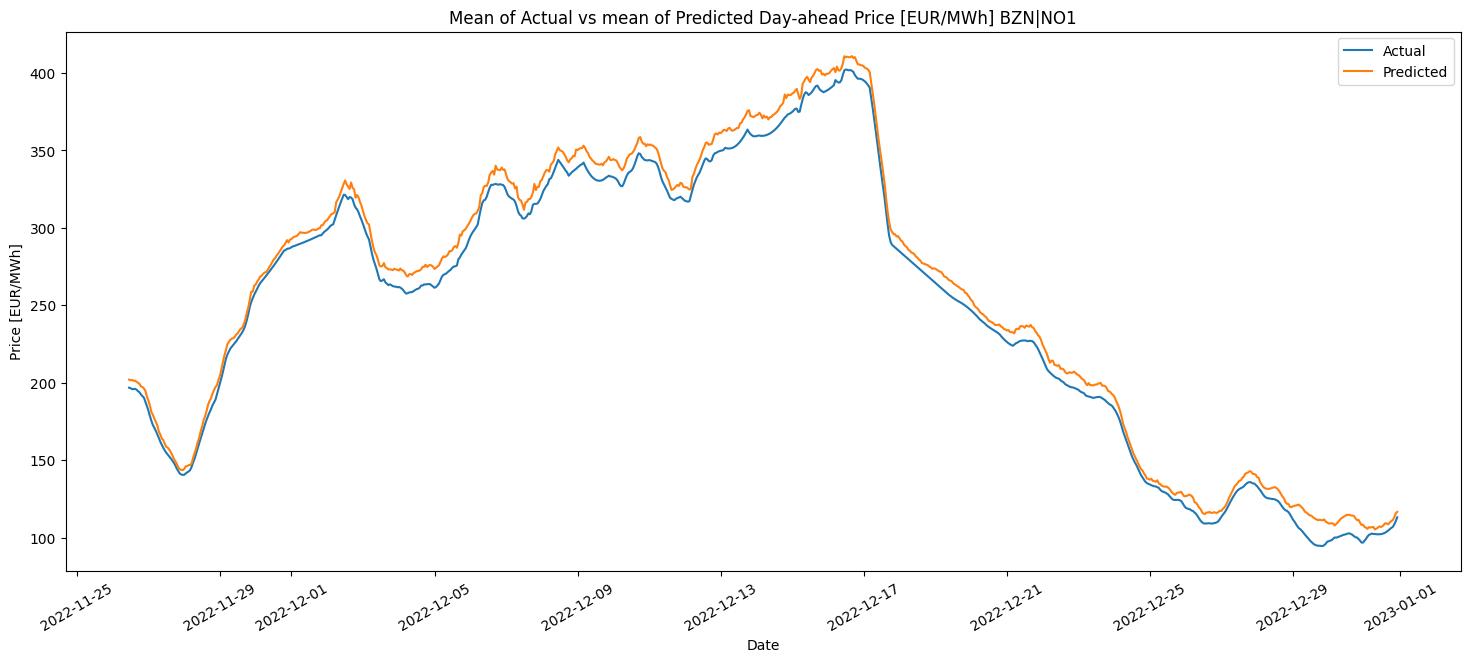

In [11]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(y_test.index, np.mean(y_test, axis=1), label='Actual')
plt.plot(y_test.index, np.mean(predicted_values, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Hyperparameter Tuning on Ridge Regression

In [41]:
params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
}

ridge = Ridge()

ridge_regressor = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(X_train, y_train)

print(ridge_regressor.best_params_)

{'alpha': 1}


In [13]:
# Create a Ridge Regression model with the optimal hyperparameters
model = ridge_regressor.best_estimator_

# Fit the model to the training set
model.fit(X_train, y_train)

Ridge(alpha=10000)

In [14]:
# Make a prediction on the training set
predicted_train = model.predict(X_train)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Mean absolute error:             7.889853096140022
Mean absolute percentage error:  0.040676283458334635
Mean squared error:              100.21470435756169
Rood mean squared error:         10.010729461810547


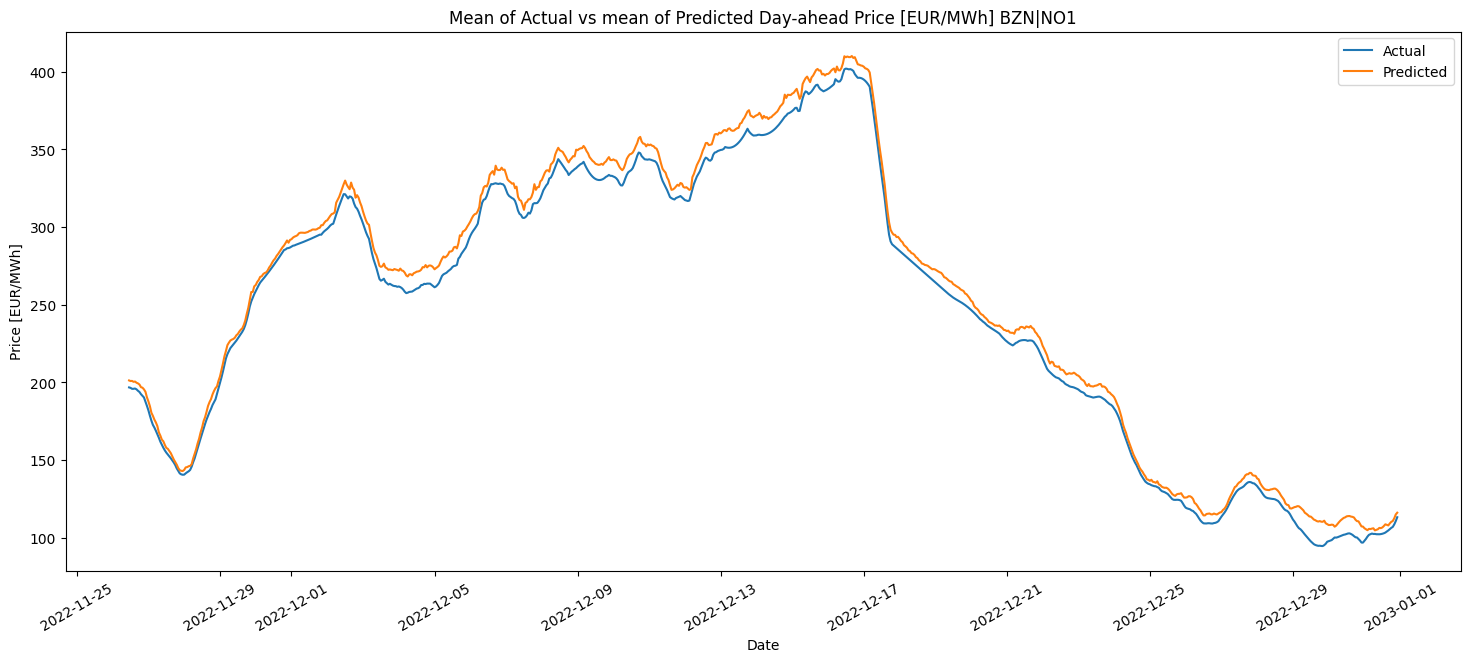

In [15]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(y_test.index, np.mean(y_test, axis=1), label='Actual')
plt.plot(y_test.index, np.mean(predicted_values, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Lasso Regression with scaled data

In [16]:
Sc = StandardScaler()
X_train = Sc.fit_transform(X_train)
X_test = Sc.transform(X_test)

In [17]:
params = {
    'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'max_iter': [100000]
}

lasso = Lasso()

lasso_regressor = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=5)

lasso_regressor.fit(X_train, y_train)

print(lasso_regressor.best_params_)

{'alpha': 0.1, 'max_iter': 100000}


In [39]:
# Create a Lasso Regression model with the optimal hyperparameters
model = lasso_regressor.best_estimator_

# Fit the model to the training set
model.fit(X_train, y_train)

Lasso(alpha=0.1, max_iter=100000)

In [40]:
# Make a prediction on the training set
predicted_train = model.predict(X_train)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             2.1006226150857983
Mean absolute percentage error:  1.1183971569326914 %
Mean squared error:              36.85052310268831
Root mean squared error:         6.070463170359269

Scores on testing set
Mean absolute error:             4.609681130538538
Mean absolute percentage error:  2.608524599215149 %
Mean squared error:              48.15614280277265
Root mean squared error:         6.939462717154163


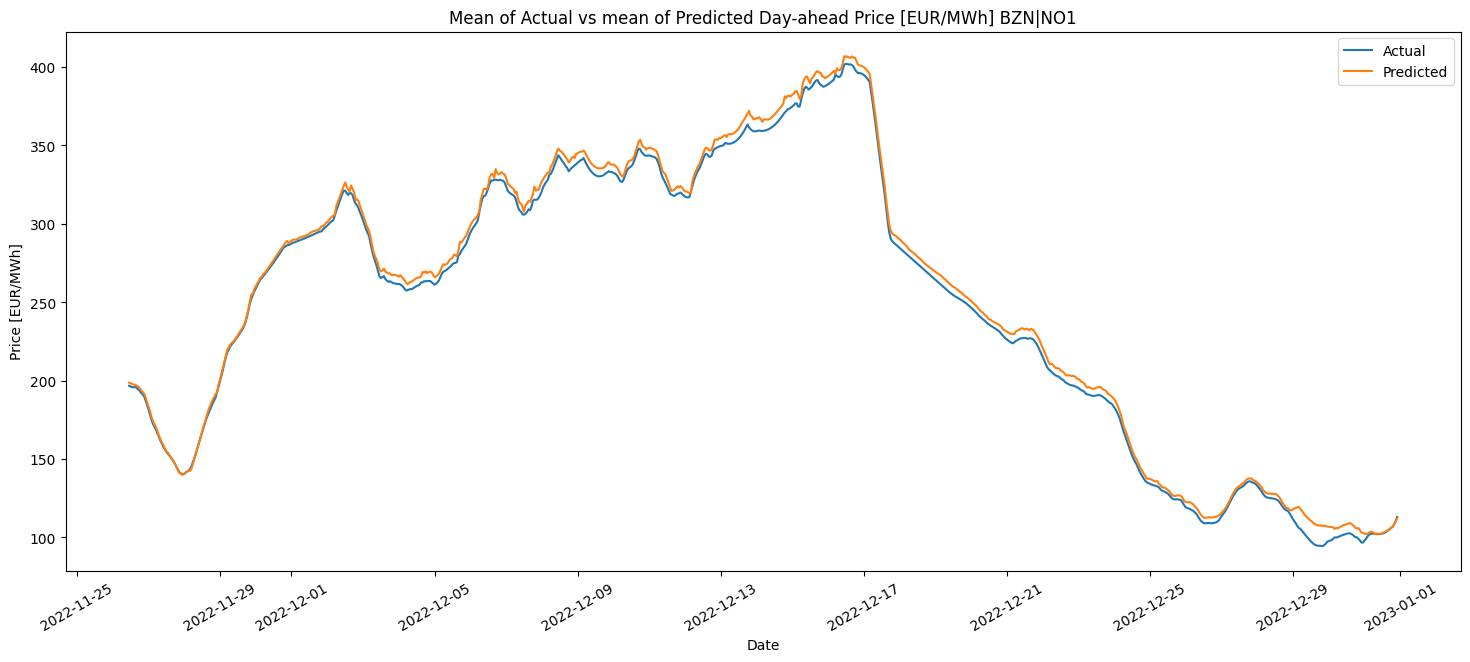

In [20]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(y_test.index, np.mean(y_test, axis=1), label='Actual')
plt.plot(y_test.index, np.mean(predicted_values, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Linear Regression with scaled data

In [36]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training set
model.fit(X_train, y_train)

LinearRegression()

In [37]:
# Make a prediction on the training set
predicted_train = model.predict(X_train)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             2.6290533057323446
Mean absolute percentage error:  1.4685851289416287 %
Mean squared error:              31.503342436220635
Root mean squared error:         5.612783840147475

Scores on testing set
Mean absolute error:             8.568252208221695
Mean absolute percentage error:  4.423182278867884 %
Mean squared error:              111.86094918062652
Root mean squared error:         10.576433670222988


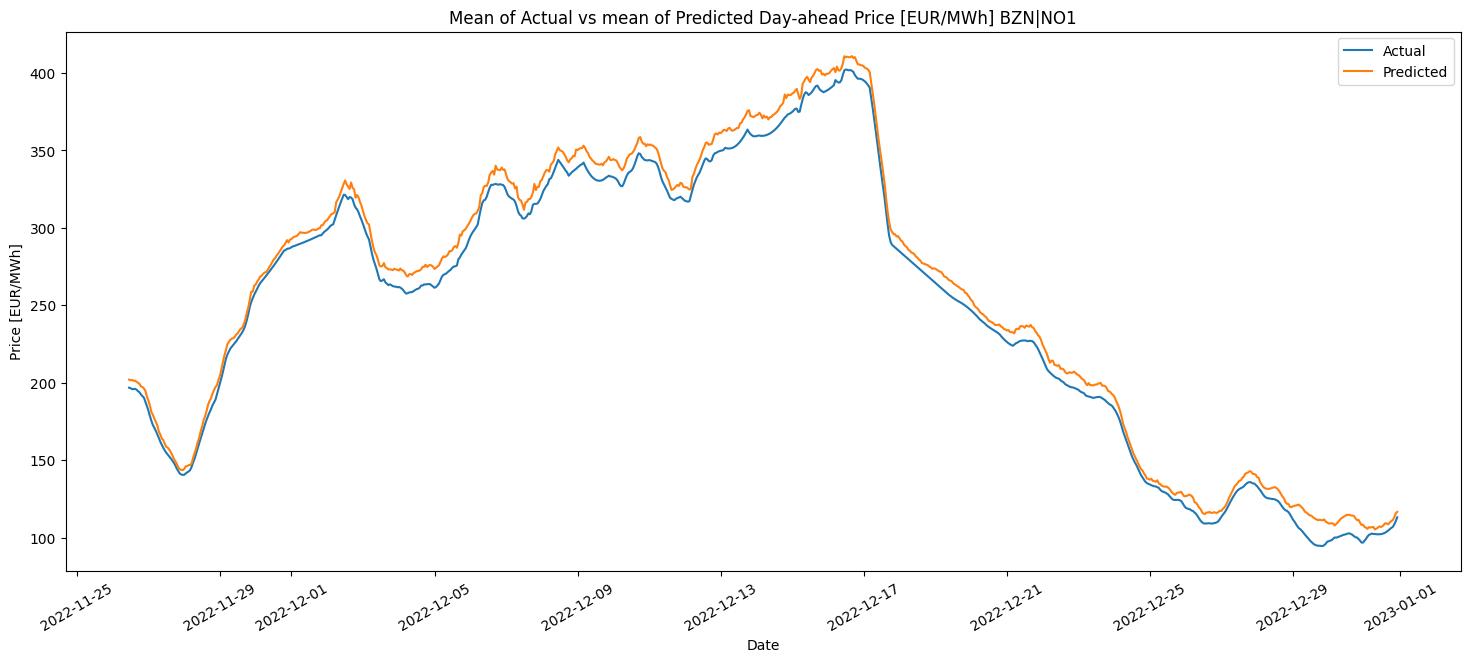

In [38]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(y_test.index, np.mean(y_test, axis=1), label='Actual')
plt.plot(y_test.index, np.mean(predicted_values, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Ridge Regression with scaled data

In [32]:
params = {
    'alpha': [0.01, 0.1, 0.5, 0.8, 0.9, 1, 1.1, 10],
}

ridge = Ridge()

ridge_regressor = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(X_train, y_train)

print(ridge_regressor.best_params_)

{'alpha': 1}


In [33]:
# Create a Ridge Regression model with the optimal hyperparameters
model = ridge_regressor.best_estimator_

# Fit the model to the training set
model.fit(X_train, y_train)

Ridge(alpha=1)

In [34]:
# Make a prediction on the training set
predicted_train = model.predict(X_train)

print('Scores on training set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_train, predicted_train)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_train, predicted_train)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_train, predicted_train)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

# Make a prediction on the testing set
predicted_values = model.predict(X_test)

print('\nScores on testing set')
# Calculate the mean absolute error (MAE) between the predicted and actual values
mae = mean_absolute_error(y_test, predicted_values)
print("Mean absolute error:            ", mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values
mape = mean_absolute_percentage_error(y_test, predicted_values)
print("Mean absolute percentage error: ", mape*100, '%')

# Calculating the mean squared error (MSE) between the predicted and actual values
mse = mean_squared_error(y_test, predicted_values)
print("Mean squared error:             ", mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values
rmse = math.sqrt(mse)
print("Root mean squared error:        ", rmse)

Scores on training set
Mean absolute error:             2.6257006949255612
Mean absolute percentage error:  1.4678911976311846 %
Mean squared error:              31.78207876668124
Root mean squared error:         5.637559646396767

Scores on testing set
Mean absolute error:             8.578020243995253
Mean absolute percentage error:  4.437998179868488 %
Mean squared error:              111.67476235653426
Root mean squared error:         10.567628038331698


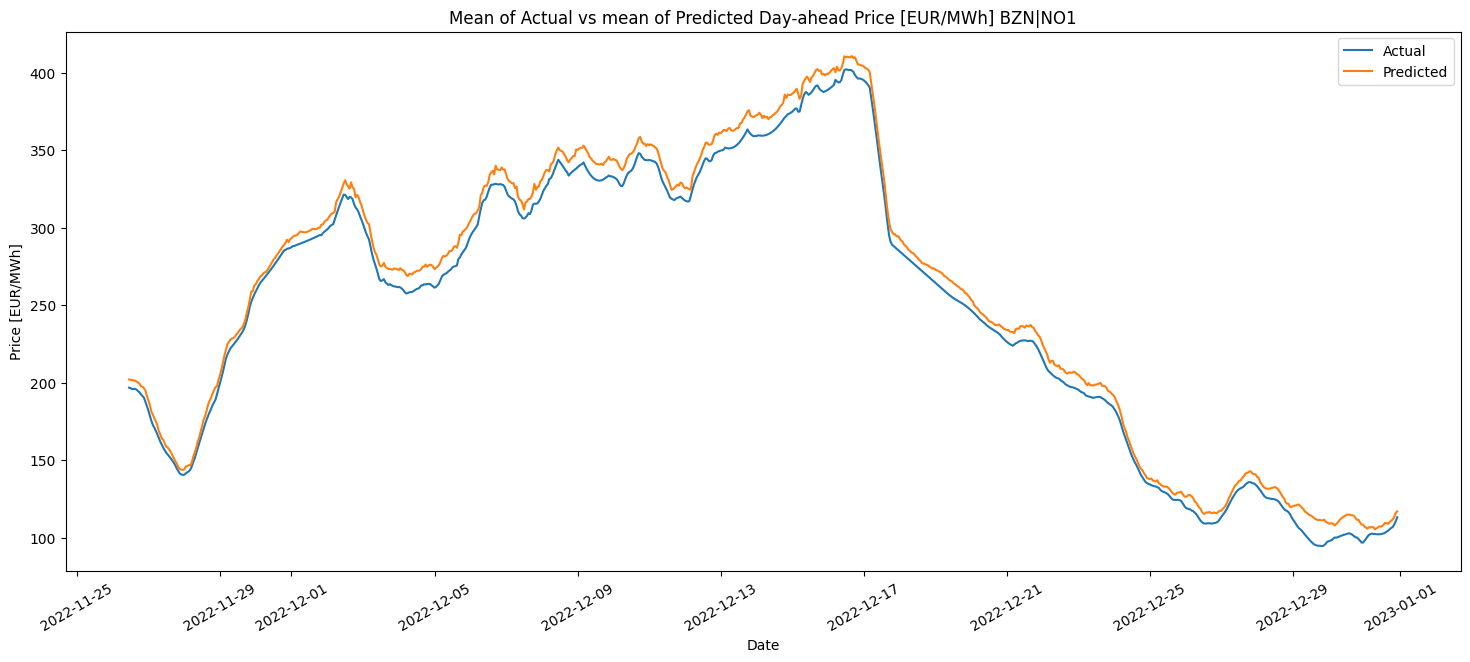

In [35]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(y_test.index, np.mean(y_test, axis=1), label='Actual')
plt.plot(y_test.index, np.mean(predicted_values, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()